# Covariance matrix for gauge data


So far, we have effectively considered cost functions of the form

    J(m) = 0.5 * misfit.T * misfit,
    
with smoothed timeseries.
Now consider cost functions of the form

    J(m) = 0.5 * misfit.T * Sigma^{-1} * misfit,

where `Sigma` is the covariance matrix associated with the **noisy** gauge data.
That is, it conveys how noise is correlated across the gauges and in time.

The noise structure varies with time.
For example, there is typically a lot of noise near the start of the observations.
Note that the GPS gauge data does not contain noise, as it has already been sampled.
The DART gauges contain less noise than the others, due to their lower sampling rate.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import os
import scipy.interpolate as si
from scipy.stats import norm

Extract the gauge data and store it in `data`, as well as the corresponding times (starting at zero) in `times`.

In [3]:
fpath = '/home/joe/src/adapt_utils/case_studies/tohoku/resources/gauges'
assert os.path.isdir(fpath)

In [4]:
gauges = ['801', '802', '803', '804',
          '806', '807', '811', '812',
          '813', '815', 'P02', 'P06',
          'KPG1', 'KPG2', 'MPG1', 'MPG2',
          '21401', '21413', '21418', '21419']
raw_data = {gauge: [float(d.split()[-1]) for d in open(os.path.join(fpath, gauge + '.dat'), 'r').readlines()] for gauge in gauges}
raw_times = {gauge: [float(d.split()[-2]) for d in open(os.path.join(fpath, gauge + '.dat'), 'r').readlines()] for gauge in gauges}

In [5]:
for gauge in gauges:
    for i, d in enumerate(raw_data[gauge]):
        if np.isnan(d):
            raw_data[gauge][i] = raw_data[gauge][i-1]  # Replace NaNs with the last finite value

In [6]:
def time_window(gauge):
    """
    Time window of interest for each gauge, to which we will truncate.
    """
    if gauge[:2] in ('80', 'P0') or gauge in ('KPG1', 'KPG2', '21418'):
        return 0, 60*60
    elif gauge[0] == '2':
        return 50*60, 120*60
    else:
        return 80*60, 120*60

In [7]:
data = {}
times = {}
for gauge in gauges:
    st, et = time_window(gauge)
    data[gauge] = [d for d, t in zip(raw_data[gauge], raw_times[gauge]) if st < t < et]
    times[gauge] = [t for t in raw_times[gauge] if st < t < et]

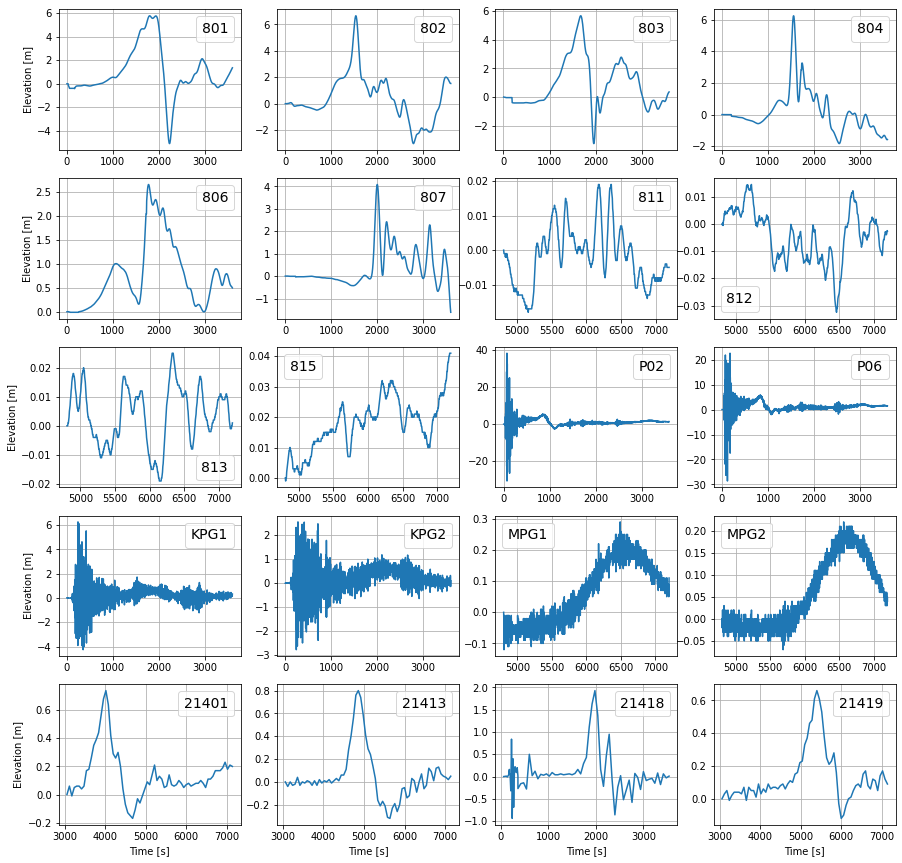

In [8]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(15, 15))
for i, g in enumerate(gauges):
    ax = axes[i//4, i % 4]
    ax.plot(times[g], np.array(data[g]) - data[g][0], label=g)
    leg = ax.legend(handlelength=0, handletextpad=0, fontsize=14)
    for item in leg.legendHandles:
        item.set_visible(False)
        if i % 4 == 0:
            ax.set_ylabel('Elevation [m]')
        if i//4 == 4:
            ax.set_xlabel('Time [s]')
        ax.grid(True)

Whilst the noise levels for P02, P06, KPG1 and KPG2 are time-dependent, they may broadly be separated into noise associated with the earthquake wave propagating through the earth and the "background" noise associated with the measurement device.
The former decays with time and the latter may be assumed constant.
Let's just ignore noise due to the earthquake by truncating the time windows of interest and assume a constant variance for each gauge.
Then the covariance matrix is diagonal and trivially invertible.
That is, we effectively have a cost function

$$
    J(m) = \frac12\sum_{g\in\mathcal G} \frac1{\sigma_g^2}(\eta(\mathbf x_g,t)-\eta_g(t))^2.
$$

Assuming a *linear* tsunami propagation model, the uncertainties in the observations map to uncertainties in the source under
$$
    \frac{\mathrm dJ}{\mathrm d\eta_0}.
$$

In [9]:
def time_window(gauge):
    """
    Time window of interest for each gauge, to which we will truncate.
    """
    if gauge[:1] in ('8', 'P'):
        return 10*60, 60*60
    elif gauge in ('KPG1', 'KPG2', '21418'):
        return 20*60, 60*60
    elif gauge[0] == '2':
        return 50*60, 120*60
    else:
        return 80*60, 120*60

In [10]:
data = {}
times = {}
for gauge in gauges:
    st, et = time_window(gauge)
    data[gauge] = [d for d, t in zip(raw_data[gauge], raw_times[gauge]) if st < t < et]
    times[gauge] = [t for t in raw_times[gauge] if st < t < et]

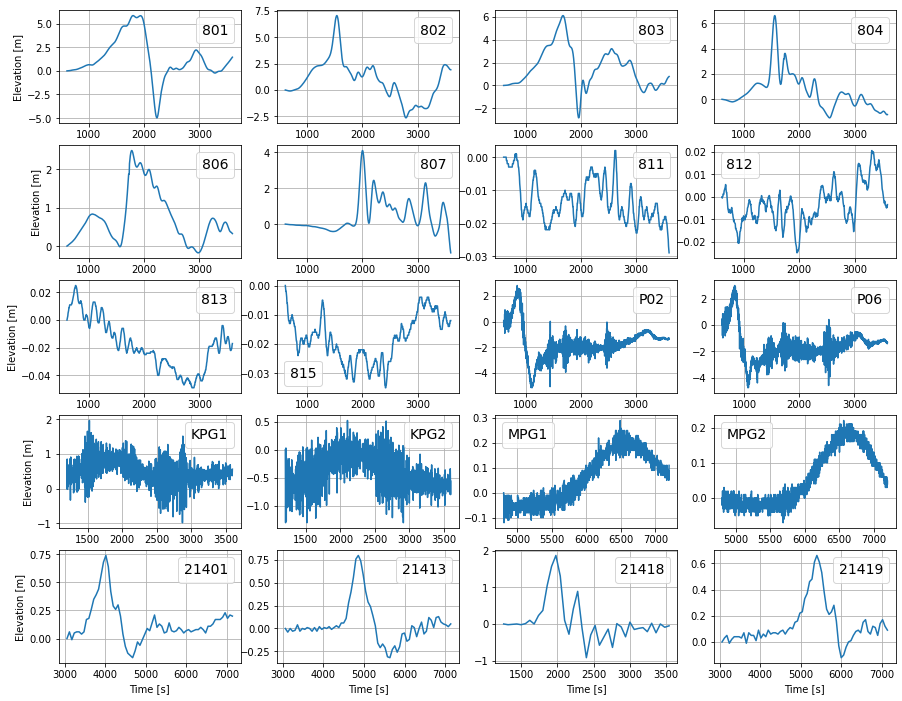

In [11]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(15, 12))
for i, g in enumerate(gauges):
    ax = axes[i//4, i % 4]
    ax.plot(times[g], np.array(data[g]) - data[g][0], label=g)
    leg = ax.legend(handlelength=0, handletextpad=0, fontsize=14)
    for item in leg.legendHandles:
        item.set_visible(False)
        if i % 4 == 0:
            ax.set_ylabel('Elevation [m]')
        if i//4 == 4:
            ax.set_xlabel('Time [s]')
        ax.grid(True)

Pass each gauge timeseries through two moving average filters, sampling according to `sample`.
This enables us to get a smooth representation of the data which can be used as a baseline.

In [12]:
sampled_times = {gauge: [] for gauge in gauges}
sampled_data = {gauge: [] for gauge in gauges}

In [13]:
def sample(gauge):
    """
    Sampling rate to use for each gauge type.
    This is required because they have different
    measurement frequencies. GPS gauge data is
    not sampled because the timeseries have very
    little noise (see below).
    """
    return 60 if gauge[1:3] == 'PG' or gauge[:2] == 'P0' else 1

In [14]:
sampled_data = data.copy()
sampled_times = times.copy()
niter = 1
for outer_loop in range(3):
    for gauge in gauges:
        l = sample(gauge)
        if l > 0:
            running_data = []
            running_times = []
            N = len(times[gauge])
            for i in range(N):
                lower = max(0, i-l)
                upper = min(N-1, i+l)
                if lower == 0:
                    upper += l - i
                if upper == N-1:
                    lower -= l - N-1 + i
                try:
                    mu = np.mean(sampled_data[gauge][lower:upper])
                except Exception:
                    continue
                running_data.append(mu)
                running_times.append(sampled_times[gauge][i])
            sampled_data[gauge] = np.array(running_data)
            sampled_times[gauge] = np.array(running_times)

/home/joe/software/firedrake-no-adapt/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joe/software/firedrake-no-adapt/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


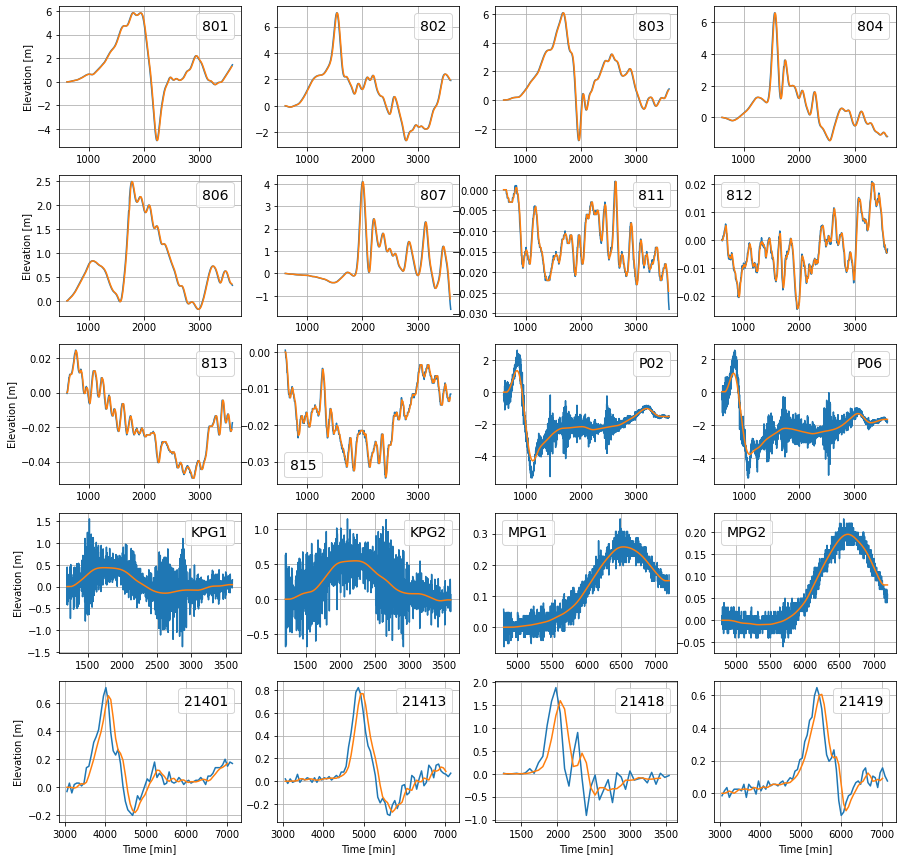

In [19]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(15, 15))
for i, g in enumerate(gauges):
    ax = axes[i//4, i % 4]
    ax.plot(times[g], np.array(data[g]) - sampled_data[g][0], label=g)
    ax.plot(times[g], np.array(sampled_data[g]) - sampled_data[g][0])
    leg = ax.legend(handlelength=0, handletextpad=0, fontsize=14)
    for item in leg.legendHandles:
        item.set_visible(False)
        if i % 4 == 0:
            ax.set_ylabel('Elevation [m]')
        if i//4 == 4:
            ax.set_xlabel('Time [min]')
        ax.grid(True)

In [16]:
kwargs = dict(fill_value='extrapolate')
interpolators = {gauge: si.interp1d(sampled_times[gauge], sampled_data[gauge], **kwargs) for gauge in gauges}

In [17]:
signed_diff = {gauge: interpolators[gauge](np.array(times[gauge])) - np.array(data[gauge]) for gauge in gauges}
diff = {gauge: np.abs(signed_diff[gauge]) for gauge in gauges}

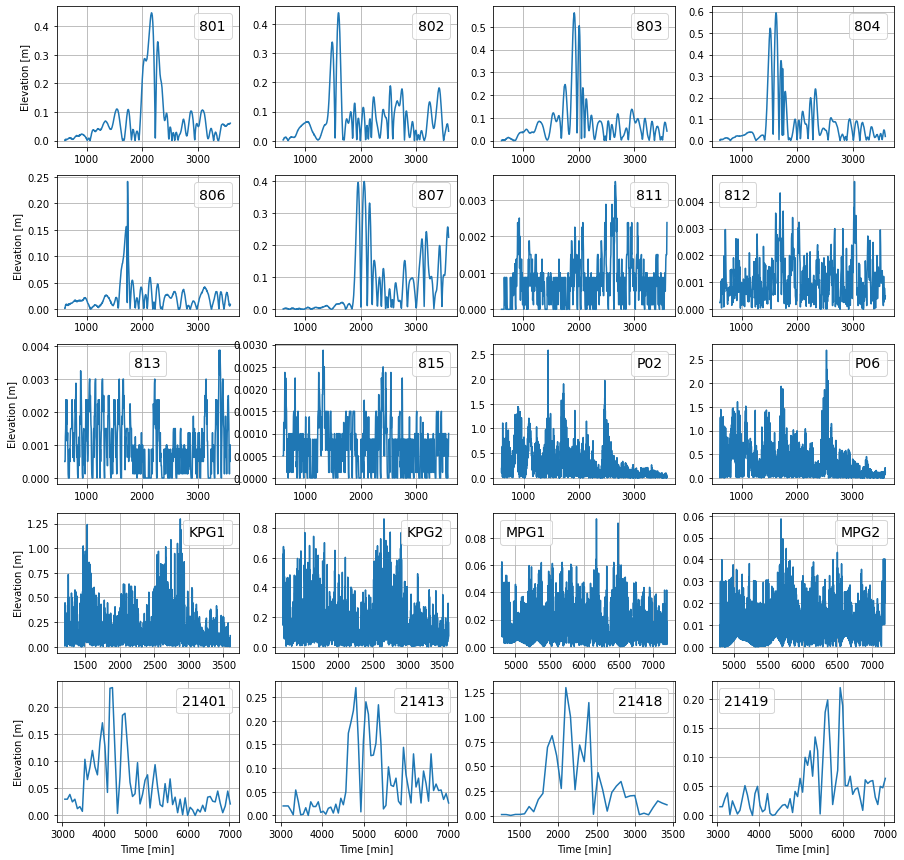

In [18]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(15, 15))
for i, g in enumerate(gauges):
    ax = axes[i//4, i % 4]
    if np.allclose(diff[g], 0.0):
        diff[g] = np.zeros(len(diff[g]))
    ax.plot(times[g], diff[g], label=g)
    leg = ax.legend(handlelength=0, handletextpad=0, fontsize=14)
    for item in leg.legendHandles:
        item.set_visible(False)
        if i % 4 == 0:
            ax.set_ylabel('Elevation [m]')
        if i//4 == 4:
            ax.set_xlabel('Time [min]')
        ax.grid(True)

Next, fit Normal distributions to samples of the data 

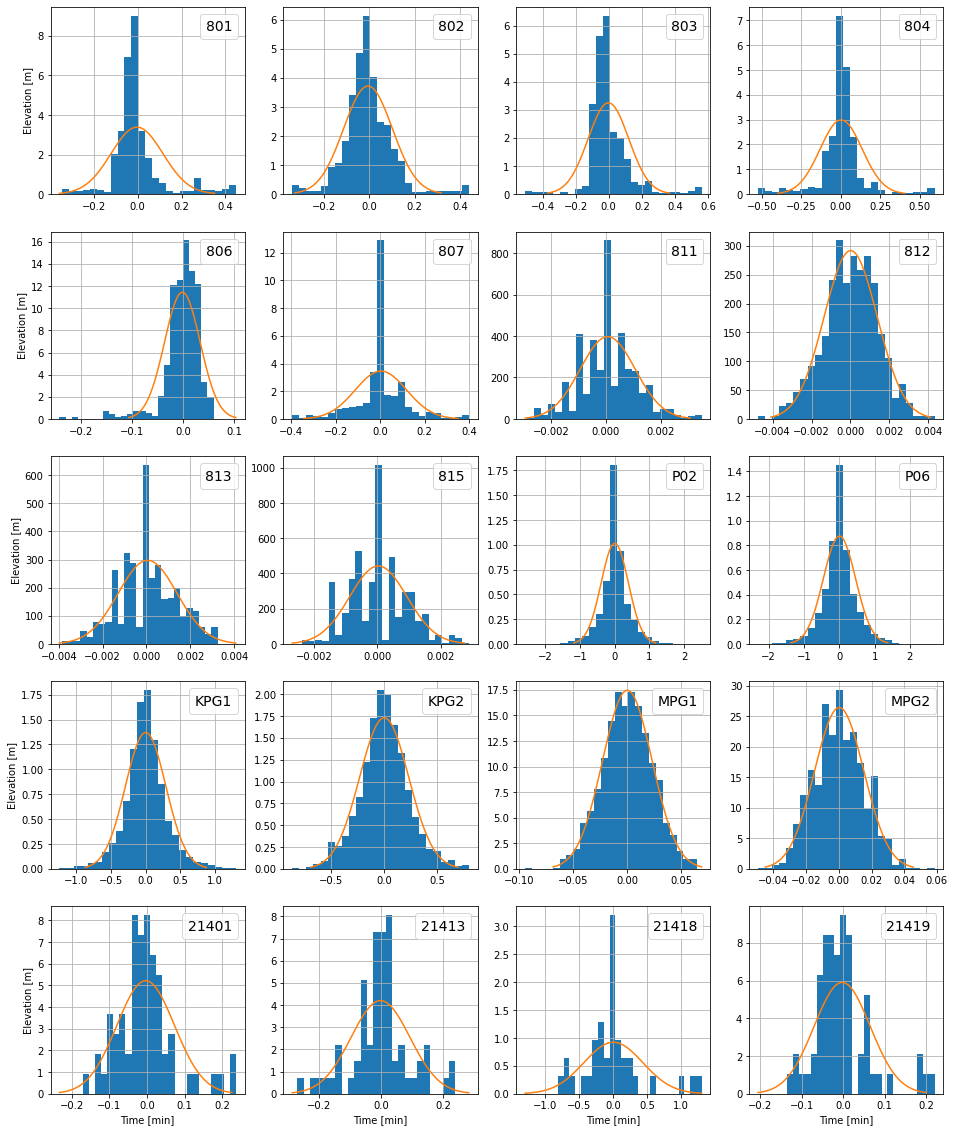

In [20]:
variances = {}
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(16, 20))
for i, gauge in enumerate(gauges):
    mu, sigma = norm.fit(np.nan_to_num(signed_diff[gauge]))
    variances[gauge] = sigma**2
    
    ax = axes[i//4, i % 4]
    ax.hist(signed_diff[gauge], 25, axes=ax, density=True)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax.plot(x, norm.pdf(x, mu, sigma), label=gauge)
    ax.grid(True)
    leg = ax.legend(handlelength=0, handletextpad=0, fontsize=14)
    for item in leg.legendHandles:
        item.set_visible(False)
        if i % 4 == 0:
            ax.set_ylabel('Elevation [m]')
        if i//4 == 4:
            ax.set_xlabel('Time [min]')
        ax.grid(True)

In [21]:
for gauge in variances:
    v = variances[gauge]
    v *= 5000  # ensure smallish values
    print("{:5s}:  {:9.4e}  {:9.4e}".format(gauge, v, 1/v))

801  :  6.9495e+01  1.4389e-02
802  :  5.7559e+01  1.7373e-02
803  :  7.5376e+01  1.3267e-02
804  :  8.9182e+01  1.1213e-02
806  :  6.0821e+00  1.6442e-01
807  :  6.6639e+01  1.5006e-02
811  :  5.0542e-03  1.9786e+02
812  :  9.3572e-03  1.0687e+02
813  :  9.0083e-03  1.1101e+02
815  :  4.0672e-03  2.4587e+02
P02  :  7.7364e+02  1.2926e-03
P06  :  1.0392e+03  9.6228e-04
KPG1 :  4.2398e+02  2.3586e-03
KPG2 :  2.6582e+02  3.7620e-03
MPG1 :  2.6104e+00  3.8309e-01
MPG2 :  1.1403e+00  8.7700e-01
21401:  2.9218e+01  3.4226e-02
21413:  4.5121e+01  2.2163e-02
21418:  9.3420e+02  1.0704e-03
21419:  2.2835e+01  4.3793e-02


### Idea:

* Invert for control parameters describing the source using such a cost function.
* Map observation uncertainties to uncertainties in the source.

A further idea is to consider different bases for the source / numbers of DoFs to analyse where the problem goes from being well-constrained to under-constrained and over-constrained.
Perhaps the uncertainty propagation will inform this.
It may even reveal where in space extra resolution is needed / there is too much.

# MPE Coffee discussion 15/04/2021

* Nearby gauges are probably not independent.
* Noise associated with a particular gauge may be to do with local turbulent effects, as well as the detector.
* Deducing stationary noise from tsunami gauge data is verging on being an inverse crime. Better to analyse data where there is no tsunami, such as in the hours prior to its arrival. An advantage of that would be that the other (non-tsunami) hydrodynamics could be assumed to be similar.
* Colin advises always using regularisation, perhaps in $H^1$ norm (or $L^2$ norm). Regularisation has a greater effect when there is less data. As the amount of data is increased, it contributes less to the cost function (proportionally).
* Colin also advises to think about things in the Bayesian context, in terms of priors and posteriors.